# Cleaning data

In [1]:
# libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# folders of imported files
folder_std = r'C:\Users\ciril\OneDrive\Desktop\ADA\MovieSummaries'

In [3]:
# import data. We will use the movie.metadata.tsv file
col_names = ['wikiID','freeID','movie_name','release_date','revenue','runtime','languages','countries','genres']
movies = pd.read_csv(folder_std + "\\movie.metadata.tsv",sep='\t',names=col_names)
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# the column release date is set to be a datetime object. We have two different formats. we solve this using a mask
release_date = pd.to_datetime(movies['release_date'],errors='coerce')
mask = release_date.isna()
second_format = pd.to_datetime(movies['release_date'][mask],format='%Y',errors='coerce')
release_date[mask] = second_format
movies['release_date'] = release_date

In [5]:
# Convert the countries, genres and languages columns to a list of countries
movies['countries'] = movies['countries'].apply(lambda x: list(json.loads(x).values()))
movies['genres'] = movies['genres'].apply(lambda x: list(json.loads(x).values()))
movies['languages'] = movies['languages'].apply(lambda x: list(json.loads(x).values()))
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


This is the movies Dataframe we will use for the rest of the project.

# Movies per year

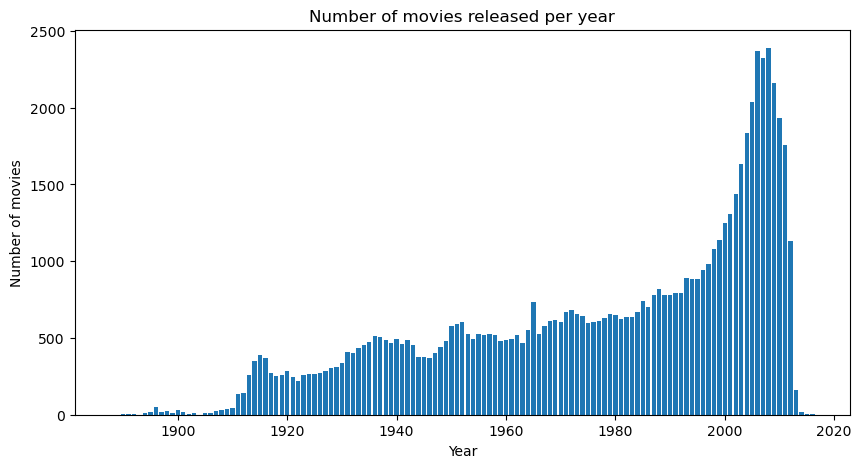

In [6]:
# we want to plot the number of movies released per year
# we group by year and count the number of movies
yearly_movies = movies.groupby(movies['release_date'].dt.year)['release_date'].count().reset_index(name='count')


# plot the number of movies per year
plt.figure(figsize=(10,5))
plt.bar(yearly_movies['release_date'],yearly_movies['count'])
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.show()

In [7]:
# we want to know how many movies were released before and after the year 2001, since this is the year of the twin towers attack
count_before2001 = yearly_movies[yearly_movies['release_date']<2001]['count'].sum()
count_after2001 = yearly_movies[yearly_movies['release_date']>=2001]['count'].sum()
print(f'Movies before the year 2001 are {count_before2001}')
print(f'Movies after the year 2001 are {count_after2001}')
print(f'The ratio of movies after the year 2001 is {count_after2001/(count_after2001+ count_before2001):.2}')  

Movies before the year 2001 are 49056
Movies after the year 2001 are 22488
The ratio of movies after the year 2001 is 0.31


The twin tower event has a relevant amount of films before (arounf 69%) and after (31%). This is a first sign that we can work analysing it through movies. 

Now, to really study arab actors, we read the actors df and work on the ethnicities.

# Ethnicity analysis

First of all, it is interesting to understand the ethnicity distribution of actors in the movies.

In [8]:
# Read the character.metadata.tsv file
col_names = ['wikiID','freeID','release_date','character_name','birth','gender','height','ethnicity_code', 'actor_name', 'age_at_release', 'freeID_character_actor_map', 'freeID_character', 'freeID_actor']
characters= pd.read_csv(open(folder_std + "\\character.metadata.tsv",encoding='utf-8'), delimiter="\t", names=col_names)

characters.head()

,wikiID,freeID,release_date,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We merge movies and character dataframes by using the freeID and wikiID, (identifiers for movies) as keys.

In [9]:
# Merge the two dataframes on the wikiID and freeID
movies_characters = pd.merge(movies, characters, on=['freeID', 'wikiID'], how='inner', suffixes=('', '_y'))

# We drop the duplicate columns
movies_characters=movies_characters.drop(['release_date_y'], axis=1)
movies_characters.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [10]:
# print the number of Actor ethnicities (Freebase ID)
eth_num = movies_characters['ethnicity_code'].unique().shape[0]
print(f'There are {eth_num} different ethnicities')


There are 480 different ethnicities


How to decode the Freebase ID to a precise ethnicity? We used a query command to the freebase API and got a database to work on.

In [11]:
# read the csv file where we decode the ethnicities ID
ethnicity_decode = pd.read_csv(folder_std + "\\ethnicity.csv",sep=',')
ethnicity_decode.columns= ['ethnicity_code', 'ethnicity_name']
ethnicity_decode.head()

,ethnicity_code,ethnicity_name
0,/m/07s8n27,Makonde people
1,/m/02k1vf,Powhatan
2,/m/0630vt,Apalachee people
3,/m/038cy,Germanic peoples
4,/m/03gq7tt,Hän people


In [12]:
# merging the two dataframes
movies_characters_eth= pd.merge(movies_characters, ethnicity_decode, how='left', left_on=['ethnicity_code'], right_on=['ethnicity_code'])
movies_characters_eth.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN


Did the ethnicity_decode work for all the freeID?

In [13]:
# filter the movies that have an eyhnicity_code but not the ethnicity_name
not_filtered= movies_characters_eth[movies_characters_eth['ethnicity_code'].notna() * movies_characters_eth['ethnicity_name'].isna()].copy()
print(f'characters not decoded: {not_filtered.shape[0]}')
print(f'portion of characters not decoded: {not_filtered.shape[0]/movies_characters_eth.shape[0]:.2}')

eth_not_decoded=not_filtered['ethnicity_code'].unique().shape[0]

eth_not_decoded_portion= eth_not_decoded/ movies_characters_eth['ethnicity_code'].unique().shape[0]
not_filtered['ethnicity_code'].unique().shape[0]

print(f'ethnicities not decoded {eth_not_decoded}')
print(f'portion of ethnicities not decoded {eth_not_decoded_portion:.2}')

characters not decoded: 50587
portion of characters not decoded: 0.11
ethnicities not decoded 158
portion of ethnicities not decoded 0.33


A good portion of ethnicity codes is not decoded into ethnicity names (33%). However, it is visible that these ethnicities appear rarely in the dataset, as only 11% of characters with ethnicity code do not present a correspondant ethnicity name.

We want to find the distribution of ethnicities in the dataset. 

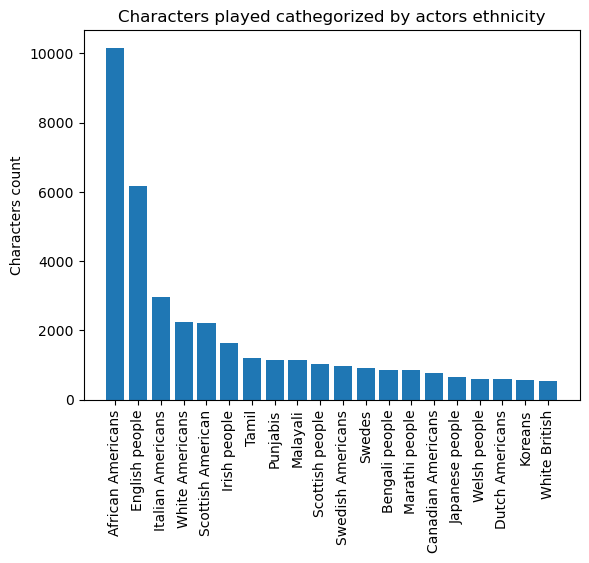

In [14]:
ethnicity_count = movies_characters_eth.groupby(movies_characters_eth['ethnicity_name'])['ethnicity_name'].count().reset_index(name = 'count')

ethnicity_count = ethnicity_count.sort_values(by='count',ascending=False)
plt.bar(ethnicity_count['ethnicity_name'].iloc[:20],ethnicity_count['count'].iloc[:20])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Characters played cathegorized by actors ethnicity')
plt.show()

In [15]:
print('In total, there are {} ethnicities of which we know the name.'.format(ethnicity_count['ethnicity_name'].shape[0]))

In total, there are 320 ethnicities of which we know the name.


To get the arabic ethnicities, we asked AI to identify ethnicities inside the list that can be considered of arabic culture. It is important to state that the arab ethnicities are really diverse and that generally anti-arab stereotypes are also linked to people of non-arab countries, but muslim. This is taken into consideration adding some ethnicities from Asia like Pakistan and Bengali.

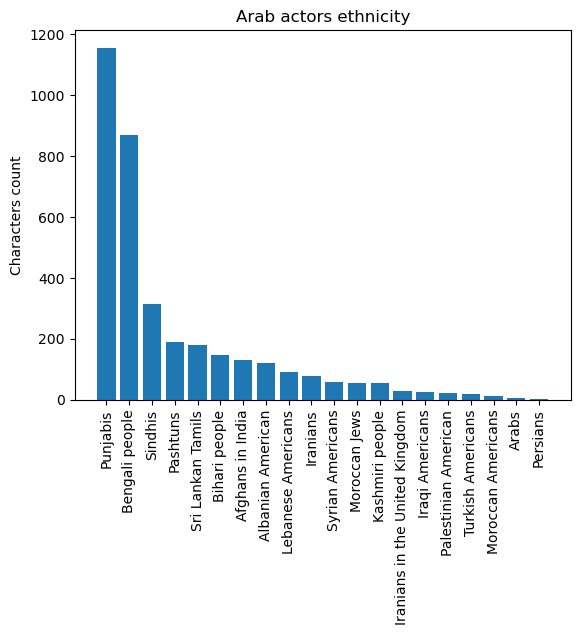

Arabic ethnicities are 20


In [16]:
# unique ethnicities
eth_unique=ethnicity_count['ethnicity_name'].unique()

# Commonly associated arab ethnicities. we used Chat GPT results
arab_ethnicities = ['Punjabis', 'Bengali people', 'Pashtuns', 'Sri Lankan Tamils', 'Bihari people', 'Sindhis', 'Kashmiri people', 'Afghans in India', 'Iranians', 'Albanian American', 'Syrian Americans', 'Moroccan Jews', 'Kurdish', 'Iraqi Americans', 'Turkish Americans', 'Lebanese Americans', 'Iranians in the United Kingdom', 'Palestinian American', 'Moroccan Americans', 'Egyptian Americans', 'Libyan Americans', 'Algerian Americans', 'Tunisian Americans', 'Yemeni Americans', 'Saudi Americans', 'Omani Americans', 'Emirati Americans', 'Qatari Americans', 'Kuwaiti Americans', 'Bahraini Americans', 'Jordanian Americans', 'Palestinians', 'Rohingya people', 'Malays', 'Indonesians', 'Bangladeshis', 'Pakistanis', 'Turks', 'Persians', 'Arabs']
# manually deleted: 'Gujarati peole'
# dubious about: 'Punjabis'

# Filter ethnicities corresponding to arab people
arab_ethnicities_subset = list(np.intersect1d(eth_unique, arab_ethnicities))

# Select only the ethnicity name of eth_unique in the arab_ethnicities_subset
arab_count = ethnicity_count[ethnicity_count['ethnicity_name'].isin(arab_ethnicities)]
arab_count=arab_count.sort_values(by='count', ascending=False)
plt.bar(arab_count['ethnicity_name'],arab_count['count'])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Arab actors ethnicity')
plt.show()

# Number of Arabic ethnicities
print('Arabic ethnicities are {}'.format(len(arab_ethnicities_subset), arab_ethnicities_subset))

In [17]:
# proportion of arab characters
print(f"From the ethnicities provided, {arab_count['count'].sum()} characters over the years are classified as arab characters.")
print(f'Proportion of arab characters w.r.t. all characters is {arab_count["count"].sum()*100/ethnicity_count["count"].sum():.3}%')

From the ethnicities provided, 3551 characters over the years are classified as arab characters.
Proportion of arab characters w.r.t. all characters is 6.4%


# Arab names analysis

The main focus of our project is the character ethnicity, not the actor ethnicity, even though they are generally related. To do so, we analyse a list of commonly arab names and we check their presence in the character name column. 

By starting to filter the Dataframe for characters with a name within the list, we then filter for movies of United States and European production. Finally, we check if these character names are present in the plot, to asses the feasibility of the sentiment analysis, to be done in the following phases of the project.

A list of arab names (male and female) is retrieved from Wikipedia and is contained in the file arab_names.txt. This list is enriched by adding common AI generated adjectives which refer to the arab and muslim culture. This is done because the column characters_name uses a general description of the character when not a primary role. Also, some names where manually deleted as ambiguous and possibly having a different cultural origin.

In [37]:
# Read the file
with open(folder_std+'/arab_names.txt', 'r') as file:
    names = file.readlines()

# Clean and format the names (with list comprehension)
arab_names = [' '.join(name.strip().split(' ')[0:-1]) if '(name)' in name else ' '.join(name.strip().split(' ')[0:-2]) if '(given name)' in name else name.strip() for name in names]

arab_names = [str(item).lower() for item in arab_names]

In [19]:
# Function to determine if the character name is an arab name
def filter_arab_names(name):
    name = str(name).lower()
    for n in arab_names:
        if n in name.split():
            return True
        
    return False

The dataframe is filtered for what are designated as "arabic characters".

This line of code is the longest of the notebook to be executed.

In [20]:
movies_characters_ar = movies_characters_eth[movies_characters_eth['character_name'].apply(filter_arab_names)]
movies_characters_ar.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
202,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],"[Family Film, Comedy]",Rahim,1923-11-11,M,NaN,/m/0dryh9k,Johnny Walker,60.0,/m/02vd0_r,/m/0h6_rbb,/m/07l4kn,NaN
564,4300418,/m/0bvx7h,The Hero: Love Story of a Spy,2003-04-11,NaN,182.0,[Hindi Language],[India],"[Thriller, Action Thrillers, Adventure, World ...",I.S.I Chief Ishak Khan,1932-06-22,M,NaN,/m/0dryh9k,Amrish Puri,70.0,/m/0k5bsd,/m/0h73qj8,/m/01k6nm,NaN


In [21]:
# Examples of character names classified as arab names
movies_characters_ar['character_name']

202                        Rahim
564       I.S.I Chief Ishak Khan
798                     Amal Raj
987                Ali La Pointe
991                       Halima
                   ...          
447804             Jamal Hassani
448077                     Nader
449075          Rev. Fred Sultan
449653                Bobby Nair
450406              Prince Akeem
Name: character_name, Length: 1501, dtype: object

In [22]:
print('The number of characters with a name classified as arab is {}.'.format(movies_characters_ar['character_name'].shape[0]))

The number of characters with a name classified as arab is 1501.


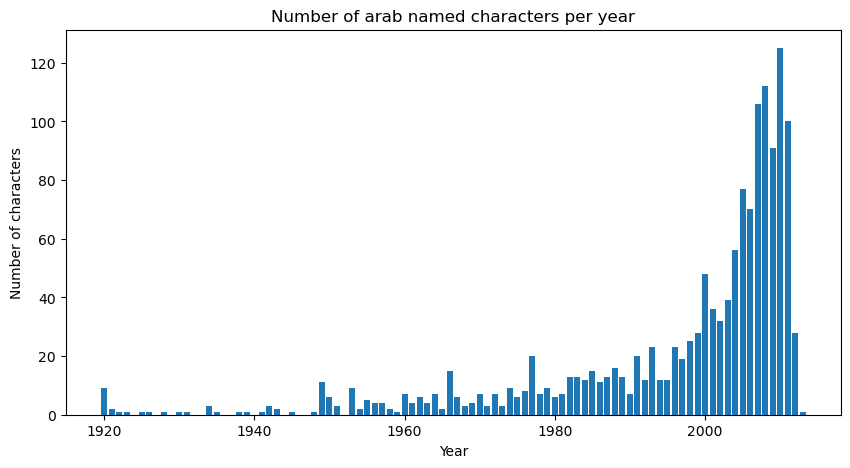

In [23]:
# How many movies with arab people per year
yearly_characters = movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'])

plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year')
plt.show()

In [24]:
# classifying the movies as before and after 2001
count_before2001 = yearly_characters[yearly_characters['release_date']<=2001]['arabs_count'].sum()
count_after2001 = yearly_characters[yearly_characters['release_date']>2001]['arabs_count'].sum()
print(f'Arab named characters before the year 2001 are {count_before2001}')
print(f'Arab named characters after the year 2001 are {count_after2001}')
print('The total is less because some movies do not have the release date (NaN).')

Arab named characters before the year 2001 are 600
Arab named characters after the year 2001 are 837
The total is less because some movies do not have the release date (NaN).


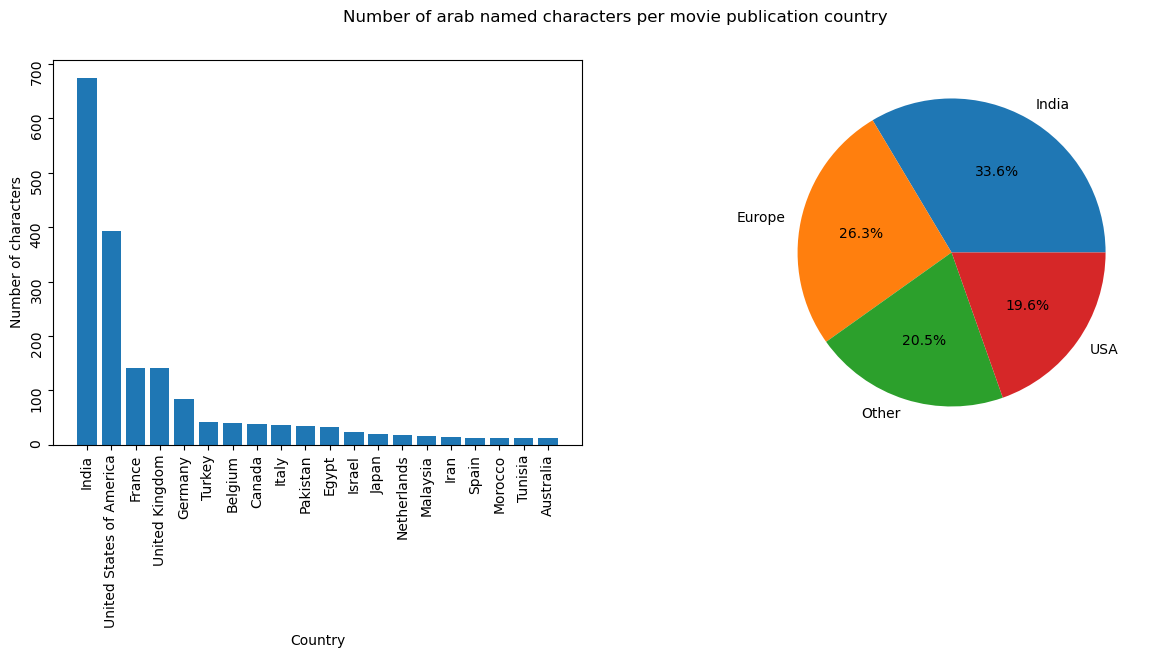

In [39]:
# Arab characters per country
exploded = movies_characters_ar.explode('countries')
country_counts = exploded['countries'].value_counts()

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(country_counts.index[:20],country_counts.values[:20])
ax[0].tick_params(labelrotation=90)
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Number of characters')
fig.suptitle('Number of arab named characters per movie publication country')

# Group USA, European countries all together, and classify the rest as 'other'
eu_countries = ['Italy','France','Germany','United Kingdom','Spain','Sweden','Denmark','Norway','Finland','Greece','Belgium','Netherlands','Switzerland','Austria','Portugal','Ireland','Poland','Hungary','Czech Republic','Romania','Bulgaria','Slovakia','Croatia','Lithuania','Latvia','Estonia','Slovenia','Cyprus','Luxembourg','Malta','Iceland','Albania','Serbia','Montenegro','Bosnia and Herzegovina','North Macedonia','Andorra','Monaco','Liechtenstein','San Marino','Vatican City']
exploded['countries'] = exploded['countries'].apply(lambda x: 'USA' if x=='United States of America' else 'Europe' if x in eu_countries else 'India' if x=='India' else 'Other')
country_grouped_counts = exploded['countries'].value_counts()

ax[1].pie(country_grouped_counts.values,labels=country_grouped_counts.index,autopct='%1.1f%%')
plt.show()


It is visible from the histogram above how the majority of arab characters are present in Indian movies. This is because arab/muslim culture is very influent in this country, for the vicinity to Arab countries.  

European countries can be considered under the United States cultural influence. Thus, it makes sense to add them into the analysis, to extend the number of characters and have a more statistically relevant sentiment analysis.

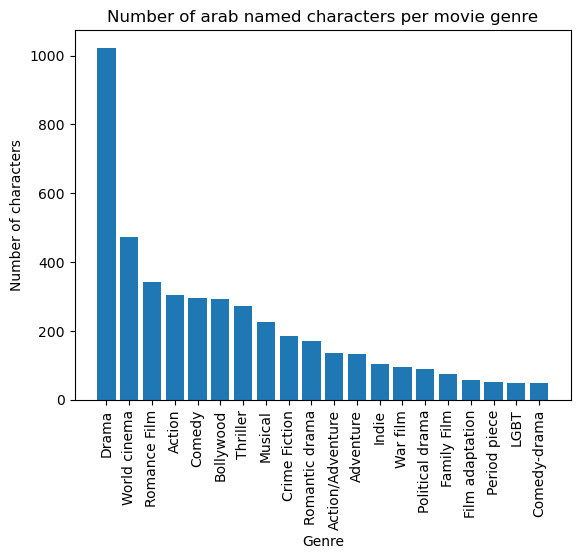

In [40]:
# Arab characters per genre
exploded = movies_characters_ar.explode('genres')
genre_counts = exploded['genres'].value_counts()
genre_counts = genre_counts.sort_values(ascending=False)
plt.bar(genre_counts.index[:20],genre_counts.values[:20])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per movie genre')
plt.show()

It is important to note that the graphs counts, both for country and genre cathegorizations, do not add up to the total number of arab characters in the Dataframe but to a larger number. This happens because some charecters are counted multiple times, as the movie they are in is classified with more than one genre or is published in more than one country. However, for our analysis it is important to have a number for the totality of each cathegories, making this graph meaningful as initial considerations before the actual project. 

As already stated, we are mainly interested in movies from USA, Canada and Europe.

In [41]:
# Filter arab movie characters from the western countries
western_countries = ['United States of America','Canada']+eu_countries
mask_characters_ar_western = movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)
movies_characters_ar_western = movies_characters_ar[mask_characters_ar_western]
print('The total number of characters from western countries is {}.'.format(movies_characters_ar_western.shape[0]))

The total number of characters from western countries is 681.


In [43]:
# Arab movie characters from western countries count before and after 2001
yearly_characters_western = movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
arab_western_before = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year<=2001].shape[0]
arab_western_after = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year>2001].shape[0]
print('The total number of characters from western countries before 2001 is {}.'.format(arab_western_before))
print('The total number of characters from western countries after 2001 is {}.'.format(arab_western_after))

The total number of characters from western countries before 2001 is 255.
The total number of characters from western countries after 2001 is 399.


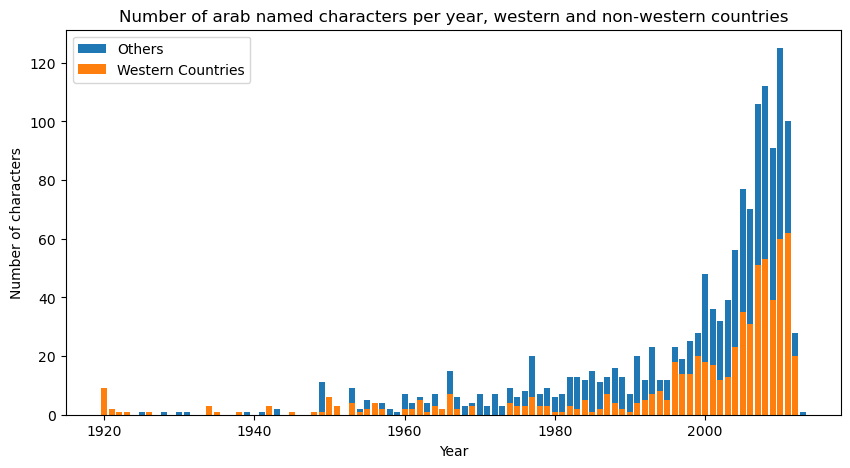

In [44]:
# Classify movies per year divided into western and non-western countries
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'],label='Others')
plt.bar(yearly_characters_western['release_date'],yearly_characters_western['arabs_count'],label='Western Countries')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year, western and non-western countries')
plt.show()

# Check the presence of arab names in the plot

It is important to verify that the characters we are considering are present in the plot. In fact, only these characters can be used for a sentiment analysis in the further stages of the project.

We want to import the plot summaries and add them to the current Dataframe, containing arab characters.

In [45]:
# import the plot summaries
plot_summaries = pd.read_csv(folder_std + "\\plot_summaries.txt",sep='\t',names=['wikiID','summary'])
plot_summaries.head()

,wikiID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [46]:
# merge the two dataframes
movies_characters_ar_we_plot= pd.merge(movies_characters_ar_western, plot_summaries, how='left', left_on=['wikiID'], right_on=['wikiID'])
movies_characters_ar_we_plot.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,summary
0,9944484,/m/04dld6,The Battle of Algiers,1966-09-03,NaN,121.0,"[French Language, Arabic Language, Italian Lan...","[Italy, Algeria]","[Crime Fiction, World cinema, Drama, War film,...",Ali La Pointe,...,M,NaN,NaN,Brahim Haggiag,NaN,/m/0k4db3,/m/0n1r4ft,/m/0k4d9h,NaN,NaN
1,9944484,/m/04dld6,The Battle of Algiers,1966-09-03,NaN,121.0,"[French Language, Arabic Language, Italian Lan...","[Italy, Algeria]","[Crime Fiction, World cinema, Drama, War film,...",Halima,...,F,NaN,NaN,Fusia El Kader,NaN,/m/0gc3wv7,/m/0n1rn10,/m/0gb_xsd,NaN,NaN


In [47]:
# function to check if a name is in the text. In this case we are looking for the name of the characters in the plot summaries.

def is_in_text(name_and_sur, text):
    # we split name_and_sur in its parts, name, possible surname or added names/titles and we make them lower case
    name_and_sur_list = [name.lower() for name in name_and_sur.split(' ')]
    # we make the text lower case
    text = text.lower()
    for name in name_and_sur_list:
        if name in text:
            return True
    return False

In [48]:
# we filter the values that are not Nan for character name and summary columns.
filter_nan = movies_characters_ar_we_plot[['character_name', 'summary']].notna().all(axis=1)
movies_characters_ar_we_plot = movies_characters_ar_we_plot[filter_nan]

# we apply the function to the dataframe and we add a column with the result, if the character name is in the summary
movies_characters_ar_we_plot['char_inplot']=movies_characters_ar_we_plot.apply(lambda x : is_in_text(x['character_name'],x['summary']), axis=1)
movies_characters_ar_we_plot.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,summary,char_inplot
3,21236198,/m/05c4c72,Thief of Damascus,NaT,NaN,78.0,[English Language],[United States of America],"[Romance Film, Fantasy, Adventure]",Khalid,...,NaN,NaN,John Sutton,NaN,/m/0g5vtqv,/m/0hnrvcw,/m/05c1xxy,NaN,634 A.D.:Though General Amdar is able to win t...,True
4,21236198,/m/05c4c72,Thief of Damascus,NaT,NaN,78.0,[English Language],[United States of America],"[Romance Film, Fantasy, Adventure]",Aladdin,...,NaN,/m/041rx,Robert Clary,NaN,/m/0hnrvc5,/m/0hnrvc8,/m/072prm,NaN,634 A.D.:Though General Amdar is able to win t...,True


In [49]:
char_percent = movies_characters_ar_we_plot['char_inplot'].sum()/movies_characters_ar_we_plot.shape[0]
print(f'Percentage of characters in the summary: {char_percent:.3}')
print(f'Number of characters in the summary: {movies_characters_ar_we_plot["char_inplot"].sum()}')
print(f'Number of characters not in the summary: {movies_characters_ar_we_plot.shape[0]-movies_characters_ar_we_plot["char_inplot"].sum()}')

Percentage of characters in the summary: 0.562
Number of characters in the summary: 290
Number of characters not in the summary: 226


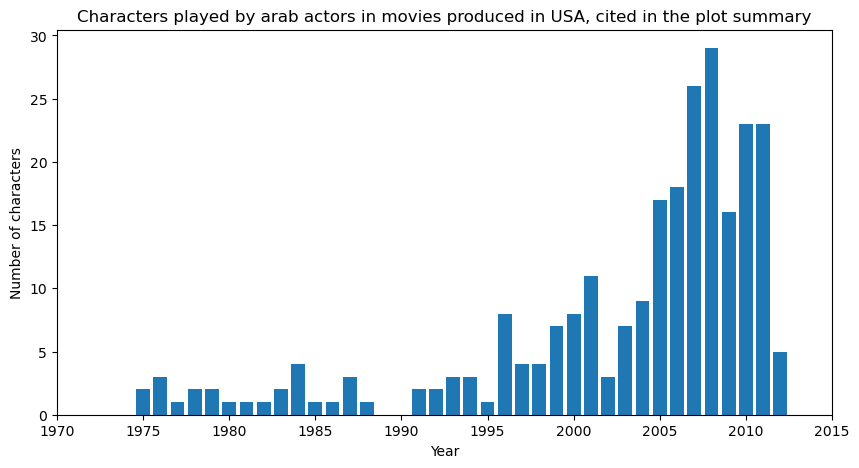

Arab characters in western-couries movies summaries before 2001 count: 103
Arab characters in western-couries movies summaries after 2001 count: 176


In [52]:
# Plot the yearly number of arab characters in movies pubblished in USA, present in the summary

plt.figure(figsize=(10,5))
yearly_ar_we_characters = movies_characters_ar_we_plot.groupby(movies_characters_ar_we_plot['release_date'].dt.year)['char_inplot'].sum().reset_index(name='characters_ar_we_inplot')
plt.bar(yearly_ar_we_characters['release_date'],yearly_ar_we_characters['characters_ar_we_inplot'])
plt.xlim(1970,2015)
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Characters played by arab actors in movies produced in USA, cited in the plot summary')
plt.show()

print(f'Arab characters in western-couries movies summaries before 2001 count: {yearly_ar_we_characters[yearly_ar_we_characters["release_date"]<=2001]["characters_ar_we_inplot"].sum()}')
print(f'Arab characters in western-couries movies summaries after 2001 count: {yearly_ar_we_characters[yearly_ar_we_characters["release_date"]>2001]["characters_ar_we_inplot"].sum()}')